# VCSUM Dataset ‑ Token Length Descriptive Statistics
此 notebook 讀取 `vcsum_data/` 內各 split 的標註檔，計算：
- **context** (全文)
- **summary** (整場摘要)
- **agenda** (段落標題)
- **discussion** (段落摘要)

的字元長度（可視為 token 近似），並輸出敘述性統計表。

## Install_package

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [5]:
from huggingface_hub import notebook_login

notebook_login()

## Get_dataset

In [2]:
# prompt: use git to got the https://github.com/hahahawu/VCSum.git

!git clone https://github.com/hahahawu/VCSum.git

Cloning into 'VCSum'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 43 (delta 13), reused 33 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 12.88 MiB | 6.64 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [3]:
%cd /content/VCSum

/content/VCSum


In [6]:
#!/usr/bin/env python3
"""
build_hf_dataset.py
把 vcsum_data/ 轉成 HuggingFace DatasetDict（train / dev / test）。
"""

import json
import pathlib
from typing import Any, Dict, List, Tuple
import argparse
import datasets         # pip install datasets

# ──────────────────────
ROOT   = pathlib.Path("vcsum_data")
SPLITS = ["train", "dev", "test"]

FEATURES = datasets.Features({
    "id"        : datasets.Value("string"),
    "av_num"    : datasets.Value("int32"),
    "context"   : datasets.Value("string"),
    "summary"   : datasets.Value("string"),
    "agenda"    : datasets.Sequence(datasets.Value("string")),
    "discussion": datasets.Sequence(datasets.Value("string")),
    "eos_index" : datasets.Sequence(datasets.Value("int32")),
    "highlights": datasets.Sequence(datasets.Value("int8")),
    "split"     : datasets.Value("string"),
})


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--root", default="vcsum_data",
                        help="資料夾路徑 (含 long_* / short_* / overall_*)")
    parser.add_argument("--out_dir", default="vcsum_hf_dataset",
                        help="輸出 HuggingFace DatasetDict 資料夾")
    return parser.parse_args()

# ────────────────────── 讀檔工具
def load_jsonl(path: pathlib.Path) -> List[Dict[str, Any]]:
    with path.open(encoding="utf-8") as fh:
        return [json.loads(l) if l.strip() else {}
                for l in fh]

# ────────────────────── 型別修正工具
def ensure_str_list(obj: Any) -> List[str]:
    if obj is None:
        return []
    if isinstance(obj, list):
        flat = []
        for x in obj:
            flat.extend(ensure_str_list(x))      # 遞迴處理巢狀 list
        return [str(s) for s in flat]
    return [str(obj)]

def ensure_int_list(obj: Any) -> List[int]:
    flat: List[int] = []
    def _walk(o):
        if o is None:
            return
        if isinstance(o, list):
            for item in o:
                _walk(item)
        else:
            try:
                flat.append(int(o))
            except (TypeError, ValueError):
                pass
    _walk(obj)
    return flat

def context_to_string(ctx: Any) -> str:
    if isinstance(ctx, str):
        return ctx
    # 將最終元素攤平成 str，再用換行符連接句子
    lines = ensure_str_list(ctx)
    return "\n".join(lines)

# ────────────────────── 建立全文 / highlight 對照表
def build_lookup_maps() -> Tuple[
    Dict[Tuple[str, int], str],
    Dict[Tuple[str, int], List[int]]
]:
    ctx_map = {
        (d["id"], d["av_num"]): context_to_string(d["context"])
        for d in load_jsonl(ROOT / "overall_context.txt")
    }
    hl_map = {
        (d["id"], d["av_num"]): ensure_int_list(d["highlights"])
        for d in load_jsonl(ROOT / "overall_highlights.txt")
    }
    return ctx_map, hl_map

# ────────────────────── 主流程
def main() -> None:
    ctx_map, hl_map = build_lookup_maps()
    ds_dict: Dict[str, datasets.Dataset] = {}

    for sp in SPLITS:
        long_items  = {(d["id"], d["av_num"]): d
                       for d in load_jsonl(ROOT / f"long_{sp}.txt")}
        short_items = {(d["id"], d["av_num"]): d
                       for d in load_jsonl(ROOT / f"short_{sp}.txt")}

        rows = []
        for key, s in short_items.items():
            l = long_items.get(key, {})
            rows.append({
                "id"        : key[0],
                "av_num"    : int(key[1]),
                "context"   : ctx_map.get(key,
                               context_to_string(s.get("context", l.get("context", "")))),
                "summary"   : l.get("summary", ""),
                "agenda"    : ensure_str_list(s.get("agenda")),
                "discussion": ensure_str_list(s.get("discussion")),
                "eos_index" : ensure_int_list(s.get("eos_index")),
                "highlights": hl_map.get(key, []),
                "split"     : sp,
            })

        ds_dict[sp] = datasets.Dataset.from_list(rows).cast(FEATURES)

    dataset = datasets.DatasetDict(ds_dict)
    print(dataset)           # 完整結構
    print(dataset["train"][0])  # 範例檢查

    out_dir = "content"
    dataset.save_to_disk(out_dir)
    print(f"✓ HuggingFace Dataset saved under directory: {out_dir}")

    # 上傳到 🤗 Hub（可選）
    dataset.push_to_hub("renhehuang/vcsum-meeting-summary")

if __name__ == "__main__":
    main()


Casting the dataset:   0%|          | 0/1088 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/135 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/136 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'av_num', 'context', 'summary', 'agenda', 'discussion', 'eos_index', 'highlights', 'split'],
        num_rows: 1088
    })
    dev: Dataset({
        features: ['id', 'av_num', 'context', 'summary', 'agenda', 'discussion', 'eos_index', 'highlights', 'split'],
        num_rows: 135
    })
    test: Dataset({
        features: ['id', 'av_num', 'context', 'summary', 'agenda', 'discussion', 'eos_index', 'highlights', 'split'],
        num_rows: 136
    })
})
{'id': '1_0', 'av_num': 249032688, 'context': '下一位要向大家重磅介绍的是我们云南凤云商贸有限公司董事长丁凤云。\n丁总欢迎您。\n其实三位老师我不知道大家有没有人认识，应该是认识的会比较偏多一些，因为三位老师是我们珠宝界定海神针一般存在的人物。\n今天到此就是为了向大家宣传和推广咱们这个石林海域，也是我们一种近年新发现的新的意识，正是我们珠宝人这一种不断探索不止创新的这种精神，让我们无此又一次的发掘新品。\n我在这里也代表广大的玉石爱好者，感谢三位老师的匠心精神，也感谢三位老师对推广石英彩玉文化而做出的贡献。\n谢谢。\n您好的，那今天我们的论坛在这里的正式开始了，今天在我们的现场是有几个小问题要问到我们的老师，首先其实我很好奇，就是我们云南是一个预持旅游的发展大势。\n那么立足于这样的一个形式，挖掘石林彩域的文化价值及推广石林彩域，您认为是应该如何来进行呢？\n老师可以发表一下自己的观点。\n石英彩玉在玉石这个大家当中是一个只有十几年年龄的新的一种。\n我旁边这位是我们中国的翡翠话题，在我进入这个行

Saving the dataset (0/1 shards):   0%|          | 0/1088 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/135 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/136 [00:00<?, ? examples/s]

✓ HuggingFace Dataset saved under directory: content


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
from datasets import load_from_disk
import pandas as pd
from pathlib import Path
import os

# 設定儲存路徑
dataset_dir = '/content/VCSum/content'
out_dir = './vcsum_csv'
Path(out_dir).mkdir(parents=True, exist_ok=True)

# 載入本地 HuggingFace DatasetDict
ds = load_from_disk(dataset_dir)
print(ds)

# 逐 split 匯出 CSV
for split, d in ds.items():
    df = d.to_pandas()
    csv_path = Path(out_dir) / f"{split}.csv"
    df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    print(f"Exported {split} to {csv_path}")

# 列出輸出檔案
print("\nFiles in out_dir:")
print(os.listdir(out_dir))


DatasetDict({
    train: Dataset({
        features: ['id', 'av_num', 'context', 'summary', 'agenda', 'discussion', 'eos_index', 'highlights', 'split'],
        num_rows: 1088
    })
    dev: Dataset({
        features: ['id', 'av_num', 'context', 'summary', 'agenda', 'discussion', 'eos_index', 'highlights', 'split'],
        num_rows: 135
    })
    test: Dataset({
        features: ['id', 'av_num', 'context', 'summary', 'agenda', 'discussion', 'eos_index', 'highlights', 'split'],
        num_rows: 136
    })
})
Exported train to vcsum_csv/train.csv
Exported dev to vcsum_csv/dev.csv
Exported test to vcsum_csv/test.csv

Files in out_dir:
['dev.csv', 'test.csv', 'train.csv']


# EDA

In [11]:
# %% Imports & Config（取代原設定）
from datasets import load_from_disk
import pandas as pd
from pathlib import Path
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

DATA_DIR   = Path("content")                 # Dataset 位置
TOK_MODEL  = "Qwen/Qwen2.5-1.5B"               # ← Qwen Tokenizer
MIN_TOKLEN = 5
MAX_TOKLEN = 8192                            # 建議依 Qwen 版本調整


In [12]:
# %% 1‑1 讀取並轉成 DataFrame
ds = load_from_disk(DATA_DIR)
df = pd.concat([ds[sp].to_pandas() for sp in ds], ignore_index=True)

print(f"總筆數：{len(df):,}")
display(df.head(3))


總筆數：1,359


,id,av_num,context,summary,agenda,discussion,eos_index,highlights,split
0,1_0,249032688,下一位要向大家重磅介绍的是我们云南凤云商贸有限公司董事长丁凤云。\n丁总欢迎您。\n其实三位...,,[推广石林彩玉文化的方式],[推广石林彩玉的文化时首先要有一个正确的推广方向，要有资金的支持，还要有专家给技术组的支撑，...,[],[],train
1,1_1,249032688,好，谢谢海林老师，非常感谢在场的观众朋友们，他的特质构造，哪位老师愿意来给我们讲解一下，怎么...,,[石林彩玉的优势],[石林彩玉跟别的玉石不同，它的颜色非常丰富，反差较大，对比特别鲜明，而且玉石里面有山川流水，...,[],[],train
2,1_2,249032688,谢谢。\n谢谢我们老师的精彩发言。\n那么同样，看看我们三位老师的影响力有多大？\n已经开始...,,[成为大众能够消费的玉的办法],[首先可以采用网上的消费模式进行大面积的推广，然后可以分层销售有钱的选高档的，没钱选低档的，...,[],[],train


In [13]:
# %% 1‑2 重複 / 缺失 / 格式檢查
# 重複 id+av_num 視為同一筆
dup_mask = df.duplicated(subset=["id", "av_num"])
print(f"重複筆數：{dup_mask.sum()}")

# 缺失欄位統計
na_counts = df.isna().sum()
print("缺失值統計：")
print(na_counts[na_counts > 0])

# 可視需要 drop / fill
df = df[~dup_mask].reset_index(drop=True)


重複筆數：0
缺失值統計：
Series([], dtype: int64)


## 基本文字指標

In [29]:
# %% 3‑1 Tokenize 全量文本
tokenizer = AutoTokenizer.from_pretrained(TOK_MODEL)

def tok_len(text: str) -> int:
    return len(tokenizer.encode(text, add_special_tokens=False))

df["tok_cnt"] = df["context"].apply(tok_len)


In [16]:
# %% 3‑2 敘述性統計
stats = df["tok_cnt"].describe(percentiles=[.5, .9, .95, .99])
print(stats)

count    1359.000000
mean     1465.966152
std       906.067822
min       115.000000
50%      1262.000000
90%      2524.600000
95%      3159.200000
99%      4829.880000
max      8449.000000
Name: tok_cnt, dtype: float64


In [30]:
mask = df["tok_cnt"] == 8449
df_8449 = df.loc[mask].copy()

print(f"符合條件的列數：{len(df_8449)}")
df_8449.head()

符合條件的列數：1


,id,av_num,context,summary,agenda,discussion,eos_index,highlights,split,word_cnt,tok_cnt
1089,13_1,26231372,大家好，我叫刘文印，是登录科技的创始人，也是广东工业大学的教授。\n那陶总把这个题目发给我以...,,[区块链的应用价值],[区块链目前的应用影响力并不大，但区块链技术在信用方面的应用前景非常广阔，促进信用经济的发展...,[],[],dev,561,8449


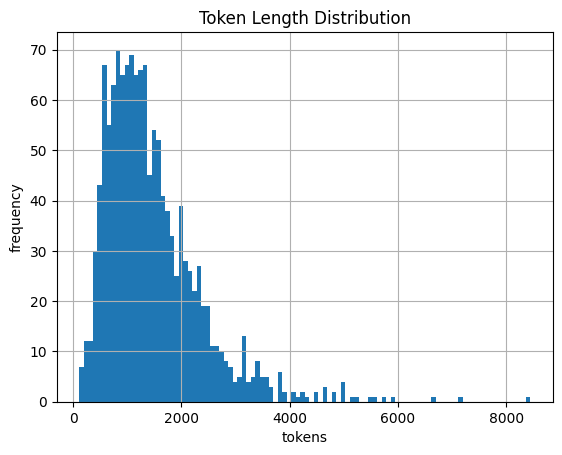

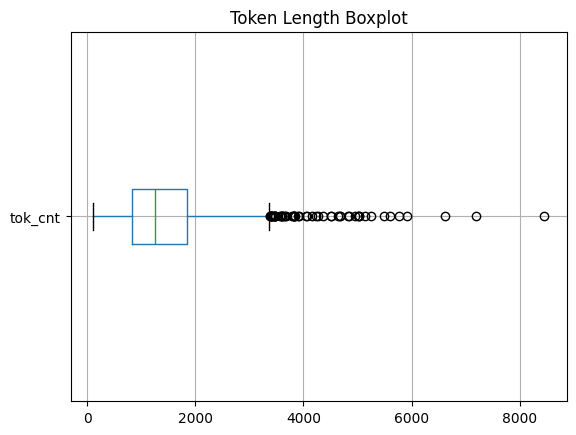

In [17]:
# %% 3‑3 視覺化分佈
plt.figure()
df["tok_cnt"].hist(bins=100)
plt.title("Token Length Distribution")
plt.xlabel("tokens")
plt.ylabel("frequency")
plt.show()

plt.figure()
df.boxplot(column="tok_cnt", vert=False)
plt.title("Token Length Boxplot")
plt.show()


## 異常質檢測

In [20]:
# %% 5‑1 匯出統計表
report = {
    "samples_total"    : len(df),
    "min_tok"          : int(stats["min"]),
    "max_tok"          : int(stats["max"]),
    "mean_tok"         : stats["mean"],
    "median_tok"       : stats["50%"],
    "p90_tok"          : stats["90%"],
    "p95_tok"          : stats["95%"],
    "p99_tok"          : stats["99%"],
}
print(report)


{'samples_total': 1359, 'min_tok': 115, 'max_tok': 8449, 'mean_tok': np.float64(1465.9661515820455), 'median_tok': np.float64(1262.0), 'p90_tok': np.float64(2524.6000000000004), 'p95_tok': np.float64(3159.199999999999), 'p99_tok': np.float64(4829.880000000001)}
